# Python Image I/O

`skia-python` supports several conversion between common data types in Python.

- [Image files](#Reading-and-writing-to-image-files)
- [NumPy array](#Numpy-array)
- [PIL Image](#Converting-image-from/to-PIL)

In [1]:
import skia
import PIL.Image
import numpy as np
import io
import matplotlib.pyplot as plt

from IPython.display import display

## Reading and writing to image files

`skia.Image` is the primary read-only image data structure in Skia. `skia.Image` can be read from an image file:

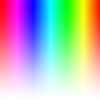

In [2]:
image = skia.Image.open('../skia/resources/images/rainbow-gradient.png')

display(image)

Or, can be exported via `skia.Surface.makeImageSnapshot` call:

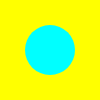

In [3]:
surface = skia.Surface(100, 100)
canvas = surface.getCanvas()
canvas.clear(skia.ColorYELLOW)
paint = skia.Paint(AntiAlias=True, Color=skia.ColorCYAN)
canvas.drawCircle((50, 50), 25, paint)
image = surface.makeImageSnapshot()

display(image)

The following resizes the image:

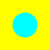

In [4]:
display(image.resize(50, 50))

Write to a specific image format is available via `skia.Image.save` or `skia.Image.encodeToImage`:

In [5]:
import os
import io
import tempfile

with tempfile.TemporaryDirectory() as t:
    image.save(os.path.join(t, 'output.png'), skia.kPNG)
    image.save(os.path.join(t, 'output.jpg'), skia.kJPEG, quality=95)
    
data = image.encodeToData(skia.kWEBP, 100)
bytes(data)[:16]

b'RIFFd\x03\x00\x00WEBPVP8L'

## NumPy array

`skia.Image` supports NumPy array import and export via `fromarray` and `toarray` methods:

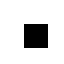

In [6]:
array = np.zeros((64, 64, 4), dtype=np.uint8)
array[24:48, 24:48, 3] = 255

image = skia.Image.fromarray(array)
display(image)

image = skia.Image.open('../skia/resources/images/rainbow-gradient.png')
array = image.toarray()

Also, NumPy arrays can be directly used as a pixel buffer behind `skia.Canvas`. This approach enables direct drawing into the given array:

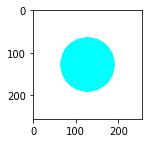

In [7]:
buffer = np.zeros((256, 256, 4), dtype=np.uint8)

canvas = skia.Canvas(buffer)
paint = skia.Paint(AntiAlias=True, Color=skia.ColorCYAN)
canvas.drawCircle((128, 128), 64, paint)
canvas.flush()

plt.figure(figsize=(2, 2))
plt.imshow(buffer)
plt.show()

One pitfall is that generic pixel format is usually unpremultiplied alpha (`skia.kUnpremul_AlphaType`), but skia defaults to premultiplied alpha (`skia.kPremul_AlphaType`). Don't forget to specify `alphaType` parameter when needed.

Many APIs in skia do not copy buffer data but only shares a reference. Therefore, buffer lifetime should be carefully taken into account when converting between different format. The following results in crash.

```python
array = np.zeros((64, 64, 4), dtype=np.uint8)
surface = skia.Surface(array)
del array

surface.makeImageSnapshot()  # This will crash
```

Canvas or surface can also export to numpy array. This is convenient when surface backend is not raster.

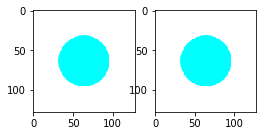

In [8]:
surface = skia.Surface(128, 128)
canvas = surface.getCanvas()
paint = skia.Paint(AntiAlias=True, Color=skia.ColorCYAN)
canvas.drawCircle((64, 64), 32, paint)

plt.figure(figsize=(4, 8))
plt.subplot(1, 2, 1), plt.imshow(canvas.toarray())
plt.subplot(1, 2, 2), plt.imshow(surface.toarray())
plt.show()

## Converting image from/to PIL

It is possible to directly convert `skia.Image`, `skia.Bitmap` or `skia.Pixmap` to `PIL.Image` using `fromarray` method.

Note that `PIL.Image` supports limited image modes. Apart from `skia.kRGBA_8888_ColorType` format, many pixel formats in skia are not compatible.

Default alpha type of `skia.Image` is `skia.kPremul_AlphaType`. To convert `skia.Image` to `PIL.Image`, make sure to first convert the alpha type before calling `fromarray`:

In [9]:
skia_image = skia.Image.open('../skia/resources/images/rainbow-gradient.png')

pil_image = PIL.Image.fromarray(skia_image.convert(alphaType=skia.kUnpremul_AlphaType))

Alternatively, use `RGBa` (premultiplied alpha mode) in `PIL.Image`:

In [10]:
pil_image = PIL.Image.fromarray(skia_image, 'RGBa')

Image is also convertible via encoded image buffer:

In [11]:
with io.BytesIO(skia_image.encodeToData()) as f:
    pil_image = PIL.Image.open(f)
    pil_image.load()  # Ensure to make a copy of buffer

Importing a `PIL.Image` requires conversion to supported color type:

In [12]:
pil_image = PIL.Image.open('../skia/resources/images/rainbow-gradient.png')
skia_image = skia.Image.frombytes(
    pil_image.convert('RGBA').tobytes(), pil_image.size, skia.kRGBA_8888_ColorType)

skia_image = skia.Image.frombytes(
    pil_image.convert('RGBX').tobytes(), pil_image.size, skia.kRGB_888x_ColorType)

skia_image = skia.Image.frombytes(
    pil_image.convert('L').tobytes(), pil_image.size, skia.kGray_8_ColorType)

Alternatively, it is possible to use encoded bytes:

In [13]:
pil_image = PIL.Image.open('../skia/resources/images/rainbow-gradient.png')

with io.BytesIO() as f:
    pil_image.save(f, 'png')
    skia_image = skia.Image.open(f)